# Setup

In [1]:
# handle math and data
import numpy as np
import pandas as pd

# to plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# handle files
import os
import sys
import joblib

# constants
SEED = 69

# Get Data

Just download data from `sklearn.datasets.fetch_olivetti_faces()` and explore the data.
- download data
- explore X, y, shapes, value types
- get an understanding of the dataset

In [2]:
from sklearn.datasets import fetch_olivetti_faces

faces_data = fetch_olivetti_faces()

In [3]:
faces_data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [4]:
X, y = faces_data.data, faces_data.target

X.shape, y.shape

((400, 4096), (400,))

So 400 images and each are 64 by 64 (4096 total pixels) grayscale images.

In [5]:
np.unique(y, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10]))

So there are 40 different faces (labeled 0 to 39) and 10 of each.

In [6]:
X[0][0]

0.30991736

In [7]:
type(X[0][0]), X.itemsize

(numpy.float32, 4)

So only 4 bytes.

In [8]:
X.size * X.itemsize

6553600

So this isn't too bad, let's check the memory size of y.

In [9]:
type(y[0])

numpy.int64

In [10]:
y.size * y.itemsize

3200

This is alright for sure.

## Visualize Faces

Create a function that plots an array of faces:
- a function that plots one face
    - reshape to 64x64 and use `plt.imshow` with `cmap="gray"`
- a function that takes an array of (4096,) face vectors and plots all of them
    - use mnist function as reference (change to 64x64 instead of 28x28)

In [11]:
some_face_ix = 178
some_face = X[some_face_ix]

some_face.shape

(4096,)

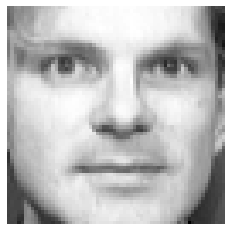

In [12]:
def plot_face(face):
    face_image = face.reshape(64, 64)
    
    plt.figure(figsize=(4,4))
    plt.imshow(face_image, cmap="gray")
    plt.axis("off")
    plt.show()

plot_face(some_face)

Cool, now let's make a function that plots many faces (I will use the mnist plot function as reference here).

In [13]:
def plot_faces(instances, images_per_row=10, **options):
    size = 64
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 64x64 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap="gray", **options)
    plt.axis("off")

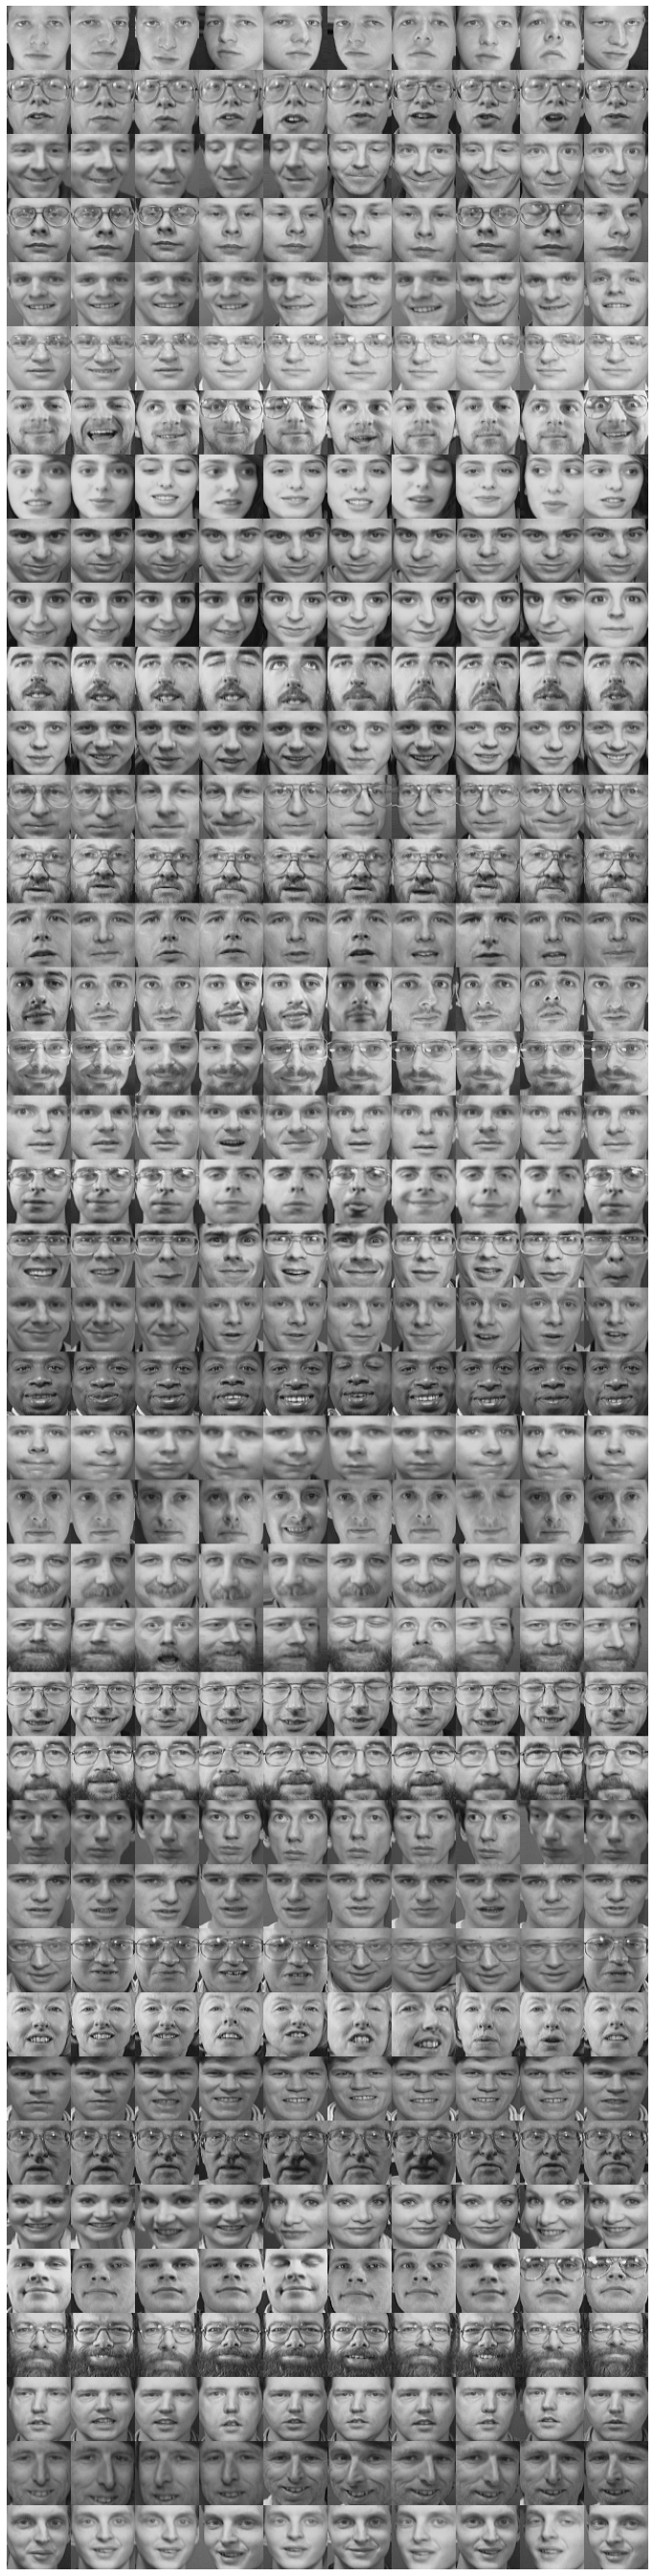

In [14]:
plt.figure(figsize=(12,100))
plot_faces(X, images_per_row=10)

As we can see, each row of 10 images is indeed the same person, just in different lighting, angle, or expressions.

## Split Train, Val, Test Sets

We need to do the following:
- Use stratified sampling for train and test sets
    - Test if stratified by running `np.unique(y_test, return_counts=True)`
- Use stratified sampling for train and val sets

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)

for train_index, test_index in skf.split(X, y):
    X_train_no_val, y_train_no_val = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

X_train_no_val.shape, X_test.shape

((320, 4096), (80, 4096))

Ok so we've split 20% off as test sets. Let's check if it's indeed a stratified split.

In [21]:
np.unique(y_train_no_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]))

In [22]:
np.unique(y_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

Indeed it is a stratified split.

In [40]:
skf = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=SEED)

for train_index, val_index in skf.split(X_train_no_val, y_train_no_val):
    X_train, y_train = X_train_no_val[train_index], y_train_no_val[train_index]
    X_val, y_val = X_train_no_val[val_index], y_train_no_val[val_index]

X_train.shape, X_val.shape

((240, 4096), (80, 4096))

Now we've split the train set into a train and val set.

In [41]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]))

In [42]:
np.unique(y_val, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

Notice we set test_size to 80, so that our validation set will have an equal number of faces per person.

In [37]:
np.argwhere(np.isnan(X)), np.argwhere(np.isnan(y))

(array([], shape=(0, 2), dtype=int64), array([], shape=(0, 1), dtype=int64))

The data is scaled from 0 to 1, has no missing values, and all values are numerical, so no need for preprocessing.
<br>
</br>
Our datasets are:
- `X_train`, `y_train`
- `X_val`, `y_val`
- `X_test`, `y_test`

# Clustering with KMeans

We will do the following:
- First try clustering with `k=40` since we know there are 40 classes of faces
    - Visualize all faces in one cluster: Are they similar?
    - Check the labels in the cluster: Are they the same?
- Next, no matter the result of the above clustering, plot an inertia vs k graph
    - Find the elbow point and cluster with that k
    - Visualize the faces in one cluster using new clusters: Are they similar?
    - Check labels in the cluster: Are they the same?

In [44]:
from sklearn.cluster import KMeans

k = 40

kmeans = KMeans(n_clusters=k, random_state=SEED)

In [50]:
X_train.shape

(240, 4096)

In [45]:
%%time
kmeans.fit(X_train)

CPU times: user 7.42 s, sys: 179 ms, total: 7.6 s
Wall time: 1.09 s


KMeans(n_clusters=40, random_state=69)

Quite fast (as expected of KMeans)!

In [47]:
kmeans.cluster_centers_.shape

(40, 4096)

This looks right - since we have 40 clusters, we should have 40 cluster centers.

In [48]:
kmeans.labels_.shape

(240,)

In [49]:
kmeans.labels_

array([18, 19,  7, 26, 16, 34, 18, 16, 19, 24, 18, 25, 30,  9, 14, 28, 32,
       29, 15, 11, 11,  4, 33,  6, 37, 16, 11, 32,  1,  1, 31, 12, 32, 38,
        2, 21, 33,  4, 14, 18,  8, 11, 12, 18, 19, 35, 18, 28, 27, 22, 18,
        1,  2, 19,  4, 15, 35, 32, 36, 10,  3, 25,  3, 16,  7,  5,  7, 27,
       22, 29, 22, 31, 33, 20,  7, 35,  0, 31, 20,  6, 14, 11,  1, 16, 13,
       30,  3,  3,  1, 29, 33, 13, 16,  1, 34, 11, 18, 32, 34,  6,  4, 32,
       13, 35, 33,  1, 23,  1, 16,  0, 18, 36, 12, 17, 16, 11,  8, 18, 18,
       19, 39, 30, 38, 23, 15, 28,  4,  5, 21, 28,  3, 37, 14, 25, 22, 13,
       36, 20, 27,  4, 16, 34,  1,  2, 12, 19, 12, 11, 18, 15, 34, 24, 27,
       16, 33, 10,  5, 20, 15, 25,  4,  1, 13, 20,  6, 31, 39, 21, 23, 10,
        3, 39, 12, 36, 27, 38, 22,  3, 21, 16, 17,  3,  3, 22, 21,  7, 15,
       32, 37,  3, 39, 20, 33,  4, 10, 29, 19,  7, 11, 21, 36, 11,  7, 25,
        3, 16, 27, 33, 13, 24,  4,  4, 31,  3, 29, 30,  6,  4, 33, 11,  4,
       32, 21, 29, 19, 26

Each label is which cluster the instance has been assigned to.

In [62]:
np.unique(y_train, return_counts=True)[1]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

We see that there are 6 faces per person in the training set. I'm interested in seeing if the 40 clusters have 6 instances each.

In [61]:
cluster_sizes = np.unique(kmeans.labels_, return_counts=True)[1]
cluster_sizes

array([ 3, 12,  4, 13, 12,  3,  5,  7,  2,  2,  4, 11,  6,  6,  4,  6, 13,
        2, 13,  8,  6,  7,  6,  4,  3,  5,  2,  7,  4,  6,  5,  5,  8,  9,
        7,  5,  5,  3,  3,  4])

Ooh, this is a pretty clear sign that some clusters do not have all the same face.

In [51]:
kmeans.inertia_

6518.19677734375

No clue how this compares to other k values yet. We will plot this for a range of k values later.

In [52]:
kmeans.n_iter_

5

Converged quite quickly.

## Visualize All Faces in a Cluster

We will do the following:
- Get array of all instances in cluster `j` of `k` clusters
    - plot that array

In [65]:
np.argwhere(cluster_sizes == 6)

array([[12],
       [13],
       [15],
       [20],
       [22],
       [29]])

We see that clusters 12, 13, 15, 20, 22, and 29 (note: these are indexes starting from 0) have only 6 instances. Let's visualize these clusters first to see if they have the same faces. Then we can try visualizing clusters with fewer or more faces.

In [66]:
# Let's get all instances of cluster 13 since it has exactly 6 faces
j = 13

cluster_j = X_train[kmeans.labels_ == j]

cluster_j.shape

(6, 4096)

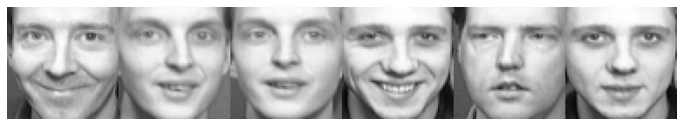

In [69]:
plt.figure(figsize=(12,6))
plot_faces(cluster_j)

Just from looking at this, there are definitely different faces. Let's look at the actual labels now.

In [70]:
y_train[kmeans.labels_ == j]

array([ 2, 39, 39, 11, 37, 11])

Looks like we got two of face `39` and two of face `11`, and all others are different (This looks about right).

Let's try a different j

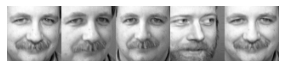

In [119]:
# cluster index 3 should have 13 instances

def plot_cluster_faces(j, X, kmeans):
    j_indices = (kmeans.labels_ == j)
    if j_indices.sum() < 2:
        print("Only one instance")
        return
    
    cluster_j = X[j_indices]
    
    plt.figure(figsize=(10,1))
    plot_faces(cluster_j, images_per_row=cluster_j.shape[0])
    plt.show()

plot_cluster_faces(1, X_train, kmeans)

This cluster definitely has many different faces.

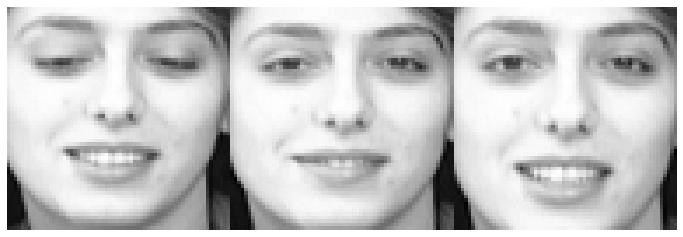

In [78]:
plot_cluster_faces(0, X_train, kmeans)

Oh? The same faces?

In [79]:
y_train[kmeans.labels_ == 0]

array([7, 7, 7])

Perhaps having more clusters and fewer instances per cluster will help with accuracy? Let's try to select an optimal value of k.

## Selecting K

We will do the following:
- Loop through a range of `k` values
    - Fit a new `kmeans` for each `k`
    - Append `kmeans.inertia_` values to inertia array
- Plot inertia (y axis) vs k (x axis)
    - Find elbow point

### Inertia vs K

In [81]:
k_values = list(range(2, 100))
inertias = []

for k_ in k_values:
    kmeans_ = KMeans(n_clusters=k_, random_state=SEED)
    kmeans_.fit(X_train)
    inertias.append(kmeans_.inertia_)

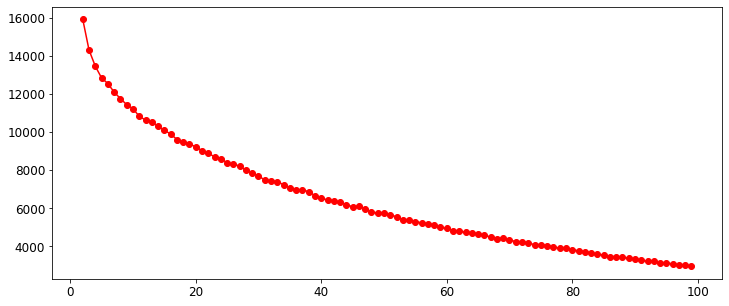

In [90]:
plt.figure(figsize=(12,5))
plt.plot(k_values, inertias, '-ro')

Hmm... It seems the elbow occurs within the first 20 k values.

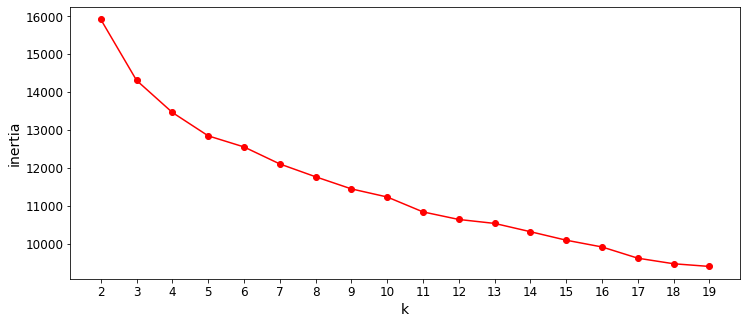

In [121]:
def plot_inertia_over_k(k_values, X):
    inertias = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=SEED)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(12,5))
    plt.plot(k_values, inertias, '-ro')
    plt.xlabel("k")
    plt.xticks(k_values)
    plt.ylabel("inertia")
    plt.show()

plot_inertia_over_k(list(range(2,20)), X_train)

There is still no clear elbow, and if k is less than 40 then we know for sure that at least one cluster has faces that aren't the same.

Let's try plotting silhouette scores.

### Silhouette Score vs K

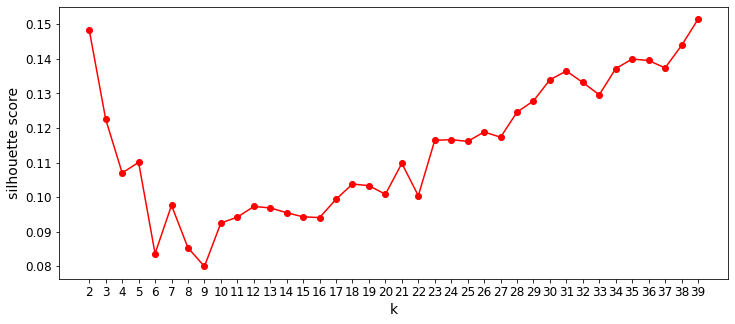

In [98]:
from sklearn.metrics import silhouette_score

def plot_silhouette_over_k(k_values, X):
    s_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=SEED)
        kmeans.fit(X)
        s = silhouette_score(X, kmeans.labels_)
        s_scores.append(s)
    
    plt.figure(figsize=(12,5))
    plt.plot(k_values, s_scores, '-ro')
    plt.xlabel("k")
    plt.xticks(k_values)
    plt.ylabel("silhouette score")
    plt.show()

plot_silhouette_over_k(list(range(2,40)), X_train)

Hmm... It seems that the max is >39? This is definitely more informative than inertia plot.

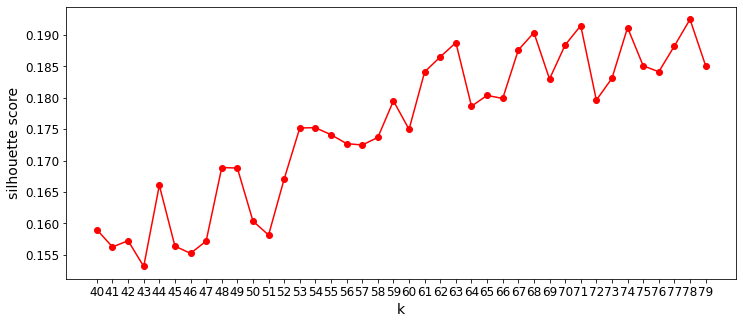

In [99]:
plot_silhouette_over_k(list(range(40,80)), X_train)

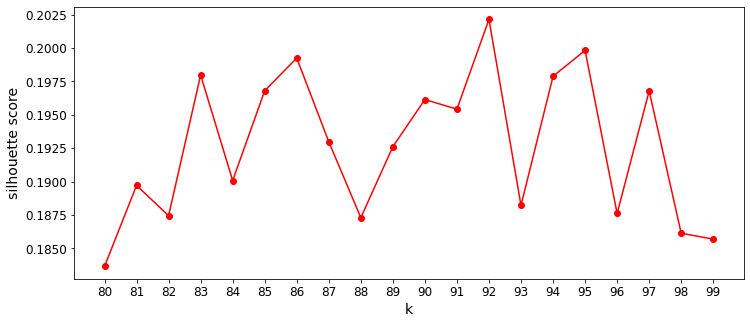

In [100]:
plot_silhouette_over_k(list(range(80,100)), X_train)

Perhaps it will start falling?

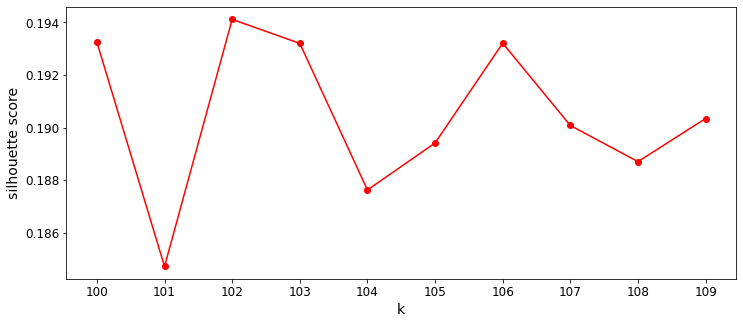

In [101]:
plot_silhouette_over_k(list(range(100,110)), X_train)

It does not seem to be increasing, so let's try using `k=92`

### K = 92

In [102]:
k = 92

kmeans = KMeans(n_clusters=k, random_state=SEED)
kmeans.fit(X_train)

KMeans(n_clusters=92, random_state=69)

CPU times: user 18.8 ms, sys: 3.7 ms, total: 22.5 ms
Wall time: 19.5 ms


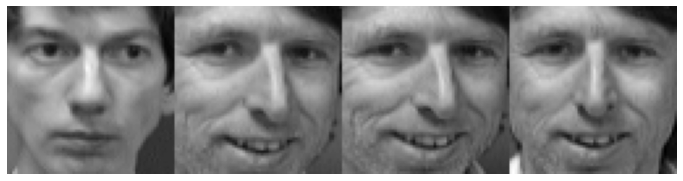

In [106]:
%%time
plot_cluster_faces(0, X_train, kmeans)

The accuracy does seem to be higher?

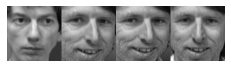

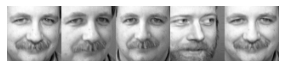

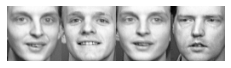

Only one instance


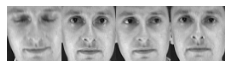

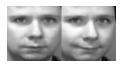

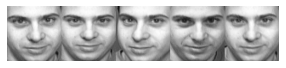

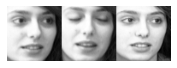

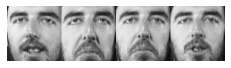

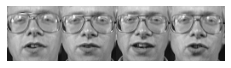

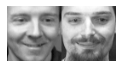

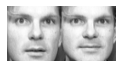

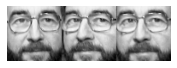

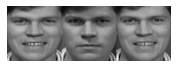

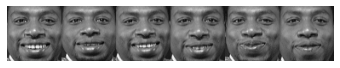

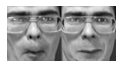

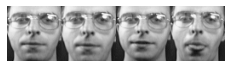

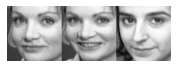

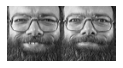

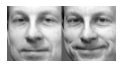

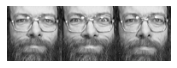

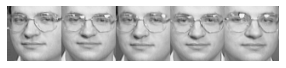

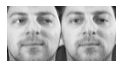

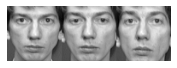

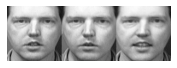

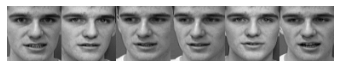

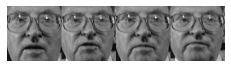

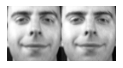

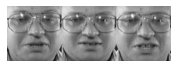

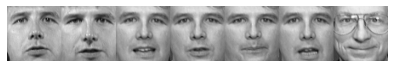

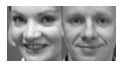

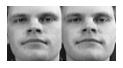

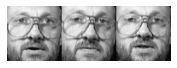

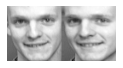

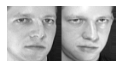

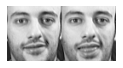

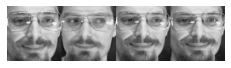

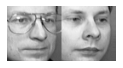

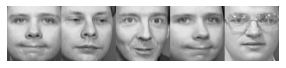

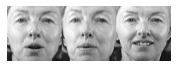

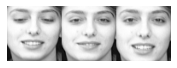

Only one instance


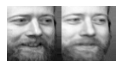

Only one instance


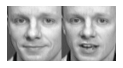

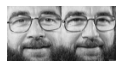

Only one instance


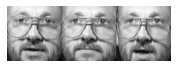

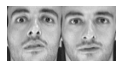

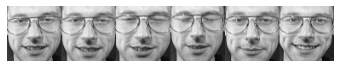

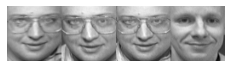

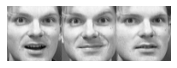

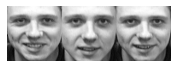

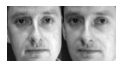

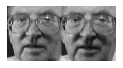

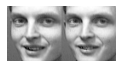

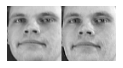

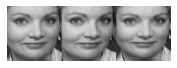

Only one instance


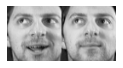

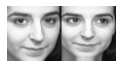

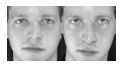

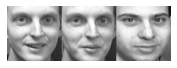

Only one instance


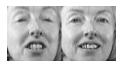

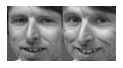

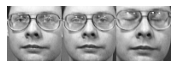

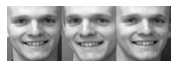

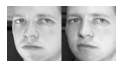

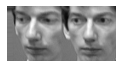

Only one instance


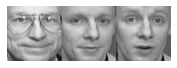

Only one instance


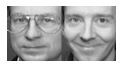

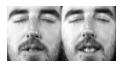

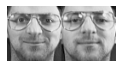

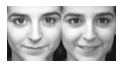

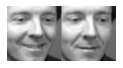

Only one instance


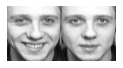

Only one instance


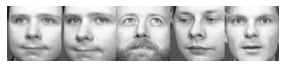

Only one instance
Only one instance
Only one instance


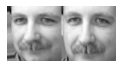

Only one instance


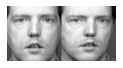

Only one instance


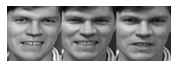

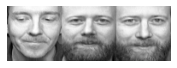

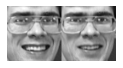

In [120]:
for j in range(0,92):
    plot_cluster_faces(j, X_train, kmeans)

With a higher k, we can see that, indeed, many clusters have all the same face!

### Check Instances in Cluster

Let's make a function that checks if all instances in a cluster are equal and returns equal ratio.
- for each cluster j
    - get indices of instances in cluster j
    - check if y of those instances are the same
    - add 1 to equal clusters sum if they are, otherwise don't add anything
- return sum of equal clusters divided by number of clusters

In [137]:
# cluster index 3 should have 13 instances

def cluster_instances_equal(y, kmeans):
    equal_clusters = 0
    n_singles = 0
    n_clusters = kmeans.n_clusters
    
    for j in range(0, n_clusters):
        j_indices = (kmeans.labels_ == j)
        if j_indices.sum() == 1:
            n_singles += 1
        else:
            cluster_j_labels = y[j_indices]

            if np.all(cluster_j_labels == cluster_j_labels[0]):
                equal_clusters += 1
    
    return (equal_clusters / (n_clusters - n_singles)), (n_singles / n_clusters)

In [138]:
cluster_instances_equal(y_train, kmeans)

(0.8051948051948052, 0.16304347826086957)

Quite good out of all clusters with more than one instance! But 16% of clusters had only one instance - which is understandable, but still not optimal.

In [139]:
def cluster_accuracy(k, X, y):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(X)
    
    print("k: ", k, "Accuracy: ", cluster_instances_equal(y, kmeans))
    
cluster_accuracy(100, X_train, y_train)

k:  100 Accuracy:  (0.8243243243243243, 0.26)


The accuracy only increased slightly, but the ratio of single instance clusters vastly increased.

In [140]:
cluster_accuracy(40, X_train, y_train)

k:  40 Accuracy:  (0.55, 0.0)


The accuracy is quite poor despite having no single instance clusters.

In [141]:
cluster_accuracy(200, X_train, y_train)

k:  200 Accuracy:  (1.0, 0.825)


100% accuracy, but with 82.5% single instance clusters? That seems rather useless.

In [142]:
for k in range(85, 97):
    cluster_accuracy(k, X_train, y_train)

k:  85 Accuracy:  (0.803030303030303, 0.2235294117647059)
k:  86 Accuracy:  (0.8181818181818182, 0.10465116279069768)
k:  87 Accuracy:  (0.7638888888888888, 0.1724137931034483)
k:  88 Accuracy:  (0.7746478873239436, 0.19318181818181818)
k:  89 Accuracy:  (0.8028169014084507, 0.20224719101123595)
k:  90 Accuracy:  (0.7887323943661971, 0.2111111111111111)
k:  91 Accuracy:  (0.7972972972972973, 0.18681318681318682)
k:  92 Accuracy:  (0.8051948051948052, 0.16304347826086957)
k:  93 Accuracy:  (0.7534246575342466, 0.21505376344086022)
k:  94 Accuracy:  (0.8026315789473685, 0.19148936170212766)
k:  95 Accuracy:  (0.8356164383561644, 0.23157894736842105)
k:  96 Accuracy:  (0.7808219178082192, 0.23958333333333334)


It seems we hit a gem? `k=86` ?

In [143]:
for k in range(76, 87):
    cluster_accuracy(k, X_train, y_train)

k:  76 Accuracy:  (0.7121212121212122, 0.13157894736842105)
k:  77 Accuracy:  (0.7941176470588235, 0.11688311688311688)
k:  78 Accuracy:  (0.7887323943661971, 0.08974358974358974)
k:  79 Accuracy:  (0.7846153846153846, 0.17721518987341772)
k:  80 Accuracy:  (0.7536231884057971, 0.1375)
k:  81 Accuracy:  (0.7536231884057971, 0.14814814814814814)
k:  82 Accuracy:  (0.7424242424242424, 0.1951219512195122)
k:  83 Accuracy:  (0.7916666666666666, 0.13253012048192772)
k:  84 Accuracy:  (0.7428571428571429, 0.16666666666666666)
k:  85 Accuracy:  (0.803030303030303, 0.2235294117647059)
k:  86 Accuracy:  (0.8181818181818182, 0.10465116279069768)


It seems `k=86` is the winner!

# Training a Model

Now that we have an optimal k value, let's train a model with and without using KMeans as a dimensionality reduction tool.
We need to do the following:
- Train a random forest classifier on training set and evaluate on validation set
- Apply dimensionality reduction with KMeans k=86 (so 86 features instead of 4096)
    - Train the same random forest classifier on the reduced set and evaluate on validation set
- Fine-tune a Pipeline that uses KMeans and RForestClassifier and tune k value with GridSearchCV
    - Evaluate on validation set
- Create a Pipeline that not only reduces with KMeans but also appends to original dataset
    - Custom class that appends reduced to original dataset
- Fine-tune k value again using new pipeline and RForestClassifier
    - Evaluate on validation set

## Only Model

Let's train a `RandomForestClassifier` and evaluate it.

In [144]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=SEED)
forest_clf.fit(X_train, y_train)
forest_clf.score(X_val, y_val)

0.9125

## Dimensionality Reduction with KMeans

We need to reduce the dimensions of `X_train` using `KMeans` with `n_clusters=86`

In [151]:
k = 86

kmeans = KMeans(n_clusters=k, random_state=SEED)
X_train_reduced = kmeans.fit_transform(X_train)

X_train_reduced.shape

(240, 86)

In [152]:
X_train_reduced[0]

array([11.617414 ,  9.291768 ,  9.07318  ,  8.6900625, 10.518079 ,
        7.463316 , 10.80284  , 10.334797 , 12.386939 ,  9.612654 ,
        7.179987 , 11.71797  , 12.780973 , 12.838532 , 12.250784 ,
        9.928138 , 13.75851  , 16.835054 ,  6.573372 , 11.446912 ,
       13.243398 , 14.992873 ,  9.438561 , 11.770479 , 10.511326 ,
        8.998778 , 12.004177 , 13.350682 ,  2.2311802,  7.7001867,
        9.600898 , 12.162873 , 10.123702 ,  9.758631 ,  8.823501 ,
       13.375916 , 12.2270975,  9.220797 , 11.647983 , 14.202628 ,
       11.127035 , 11.183419 , 12.537076 , 12.584154 ,  8.086803 ,
       10.937337 ,  7.6369934, 12.10968  , 13.431094 , 14.108289 ,
        9.289208 , 10.771928 , 10.189155 ,  7.4665446, 12.7303095,
        9.461156 , 11.826493 , 10.134318 , 10.977614 ,  8.881767 ,
        8.40792  , 12.915291 , 10.460165 , 11.835817 , 14.620848 ,
        8.722519 ,  7.977597 ,  8.864682 ,  9.394351 ,  8.970273 ,
       10.682831 , 11.224881 , 13.485169 , 11.177475 ,  8.9776

No need for feature scaling for random forest.

In [153]:
forest_clf.fit(X_train_reduced, y_train)

X_val_reduced = kmeans.transform(X_val)
forest_clf.score(X_val_reduced, y_val)

0.775

Hmm... The accuracy dropped really hard there.

## Fine-tune K with GridSearchCV

We need to do the following:
- Build a pipeline that reduces with KMeans and then classifies with Random Forest
- Fine tune k with grid search

In [154]:
from sklearn.pipeline import Pipeline

k = 86

kmeans_forest_pipe = Pipeline([
    ("kmeans", KMeans(n_clusters=k, random_state=SEED)),
    ("forest", RandomForestClassifier(random_state=SEED)),
])

In [155]:
kmeans_forest_pipe.fit(X_train, y_train)
kmeans_forest_pipe.score(X_val, y_val)

0.775

In [156]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_search = GridSearchCV(kmeans_forest_pipe, param_grid, cv=3, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=86, random_state=69)),
                                       ('forest',
                                        RandomForestClassifier(random_state=69))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=1)

In [157]:
grid_search.best_estimator_

Pipeline(steps=[('kmeans', KMeans(n_clusters=88, random_state=69)),
                ('forest', RandomForestClassifier(random_state=69))])

Wow, it seems my 86 wasn't far from the optimal cluster count!

In [158]:
grid_search.best_estimator_.score(X_val, y_val)

0.7875

Still poor accuracy.

# Append Reduced Dataset

We need to do the following:
- Append `X_train_reduced` to `X_train` and then train a classifier on it
    - Create a function that takes X_train and then creates the reduced dataset and returns the appended dataset
- Create a custom class that transforms X_train to X_train_appended
- Create a pipeline that reduces and appends to X_train and then trains RForest on it
- Fine-tune k with GridSearchCV on the pipeline

## Train on Appended Dataset

Let's first try it out using ready variables.

In [159]:
X_train_appended = np.c_[X_train, X_train_reduced]
X_train_appended.shape

(240, 4182)

In [160]:
forest_clf = RandomForestClassifier(random_state=SEED)
forest_clf.fit(X_train_appended, y_train)

X_val_appended = np.c_[X_val, X_val_reduced]
forest_clf.score(X_val_appended, y_val)

0.925

Slightly better than without appending.

In [170]:
def reduce_append(X, kmeans):
    X_reduced = kmeans.transform(X)
    
    return np.c_[X, X_reduced]

kmeans = KMeans(n_clusters=86, random_state=SEED)
kmeans.fit(X_train)

np.all(X_train_appended == reduce_append(X_train, kmeans))

True

Now that we have a function that automates reducing, let's make it into a custom class.

## Custom Class Reduce and Append

In [171]:
from sklearn.base import BaseEstimator, TransformerMixin

class KMeansReduceAppend(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
    def fit(self, X, y=None):
        self.kmeans_ = KMeans(n_clusters=self.k, random_state=SEED)
        self.kmeans_.fit(X)
        return self
    def transform(self, X):
        return reduce_append(X, self.kmeans_)

Let's create a pipeline that reduces, appends, then trains a random forest on it.

In [172]:
k = 86

reduce_append_pipeline = Pipeline([
    ("reduce_append", KMeansReduceAppend(k)),
    ("forest", RandomForestClassifier(random_state=SEED)),
])

In [173]:
reduce_append_pipeline.fit(X_train, y_train)

Pipeline(steps=[('reduce_append', KMeansReduceAppend(k=86)),
                ('forest', RandomForestClassifier(random_state=69))])

In [174]:
reduce_append_pipeline.score(X_val, y_val)

0.925

Nice!

## Fine-tune K on Reduce Append Pipeline

In [175]:
param_grid = dict(reduce_append__k=range(40, 100))
grid_search_reduce_append = GridSearchCV(reduce_append_pipeline, param_grid, cv=3, verbose=1)
grid_search_reduce_append.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('reduce_append',
                                        KMeansReduceAppend(k=86)),
                                       ('forest',
                                        RandomForestClassifier(random_state=69))]),
             param_grid={'reduce_append__k': range(40, 100)}, verbose=1)

In [176]:
grid_search_reduce_append.best_estimator_

Pipeline(steps=[('reduce_append', KMeansReduceAppend(k=46)),
                ('forest', RandomForestClassifier(random_state=69))])

Hmm... Now this is interesting! This may be because the original dataset already provides plenty of information and so you don't need as many clusters!

In [177]:
grid_search_reduce_append.best_estimator_.score(X_val, y_val)

0.925

The same accuracy though? Wierd, maybe it's because we have too few instances.

# Gaussian Mixture Models

Let's try clustering with GMMs. We can even sample new faces using our model.

## Train a BGMM

We want to train a Bayesian Gaussian Mixture Model
- apply PCA with `n_components=0.99` to X_train for compression
- train BGMM with 100 clusters on `X_train_compressed`

In [180]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_train_compressed = pca.fit_transform(X_train)

X_train_compressed.shape

(240, 177)

We've reduced 4096 features to 177. (mapping to 177 principal components from SVD using matrix multiplication)

In [181]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=100, n_init=10)
bgm.fit(X_train_compressed)

np.round(bgm.weights_, 2)

array([0.01, 0.02, 0.01, 0.02, 0.03, 0.03, 0.02, 0.02, 0.02, 0.02, 0.01,
       0.02, 0.01, 0.01, 0.02, 0.01, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.01,
       0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

## Visualize BGMM Samples

To visualize the samples we need to:
- sample an instance with `bgm`
- inverse the PCA compressed instance using `inverse_transform()`
- plot the instance

In [188]:
some_sample = bgm.sample(1)[0]
some_sample.shape

(1, 177)

In [189]:
some_sample = pca.inverse_transform(some_sample)
some_sample.shape

(1, 4096)

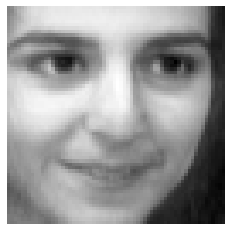

In [190]:
plot_face(some_sample)

Woahhh, it actually looks like a face!

Let's generate more.

In [196]:
def generate_sample_faces(n_samples, bgm, pca):
    samples = bgm.sample(n_samples)[0]
    faces = [pca.inverse_transform(s) for s in samples]
    return np.array(faces)

some_sample_faces = generate_sample_faces(10, bgm, pca)
some_sample_faces.shape

(10, 4096)

In [209]:
def plot_generated_faces(n_faces):
    sample_faces = generate_sample_faces(n_faces, bgm, pca)
    
    plt.figure(figsize=(10,100))
    plot_faces(sample_faces)

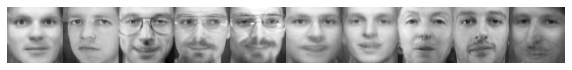

In [210]:
plot_generated_faces(10)

That's cool!

## Anomaly Detection with BGMM

Now let's try to create some anomalies and see if they are detected by `bgm`
- Modify some faces
- Detect if these are anomalies 
    - Compare their scores to a threshold of all `X_train` scores

### Modify Faces

We need to do the following:
- Generate 10 faces
- Flip them in a random direction
- Plot and see if they are flipped

In [215]:
generated_samples = generate_sample_faces(10, bgm, pca)
generated_samples.shape

(10, 4096)

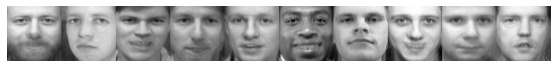

In [216]:
plt.figure(figsize=(10,1))
plot_faces(generated_samples)

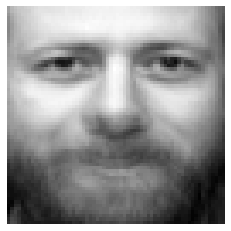

In [221]:
test_sample = generated_samples[0].copy()
plot_face(test_sample)

In [225]:
test_sample_modded = test_sample.reshape(64,64)
test_sample_modded

array([[0.57572248, 0.63674134, 0.66010562, ..., 0.45917523, 0.44074266,
        0.42291737],
       [0.57820725, 0.630454  , 0.64871432, ..., 0.46699732, 0.43836806,
        0.41992057],
       [0.55577564, 0.60768819, 0.63854467, ..., 0.47760944, 0.44007133,
        0.40769017],
       ...,
       [0.26391712, 0.34320367, 0.3446723 , ..., 0.26100663, 0.27882002,
        0.27757363],
       [0.29557188, 0.36965401, 0.35209662, ..., 0.25781101, 0.28168311,
        0.28018003],
       [0.31700174, 0.37807239, 0.36742665, ..., 0.26131792, 0.28656416,
        0.28518522]])

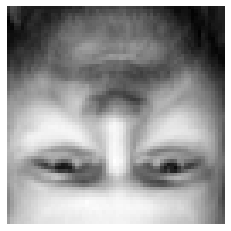

In [232]:
plot_face(np.flip(test_sample_modded, 0).ravel())

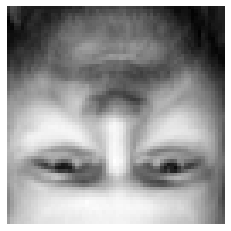

In [233]:
def vertical_flip(face):
    newface = face.copy().reshape(64,64)
    newface = np.flip(newface, 0).ravel()
    return newface

plot_face(vertical_flip(test_sample))

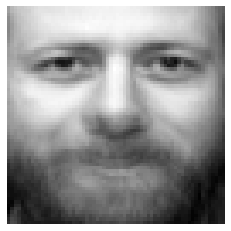

In [234]:
plot_face(vertical_flip(vertical_flip(test_sample)))

Ok this works, now let's flip all sample faces.

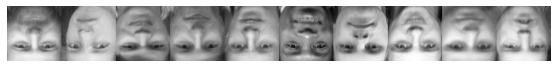

In [236]:
modded_samples = [vertical_flip(s) for s in generated_samples]

plt.figure(figsize=(10,1))
plot_faces(modded_samples)

## Detect Anomaly

We need to detect that these `modded_samples` are anomalies.
- Calculate probability densities of `X_train_compressed` with `score_samples()`
- Calculate density_threshold for anomalies
- Detect if modded_samples are anomalies by comparing their scores with density_threshold
    - PCA compress them
    - Get scores
    - Compare

In [240]:
densities = bgm.score_samples(X_train_compressed)
densities.shape

(240,)

In [241]:
densities[:10]

array([313.81966951, 312.87123232, 311.15255413, 312.7754706 ,
       312.16593172, 310.86776033, 313.03394534, 313.43953097,
       313.0291268 , 312.81045767])

In [244]:
# threshold for the bottom 5%
density_threshold = np.percentile(densities, 5)
density_threshold

310.97268596304974

In [247]:
modded_samples_compressed = pca.transform(modded_samples)
modded_densities = bgm.score_samples(modded_samples_compressed)

modded_densities < density_threshold

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Indeed, they are all anomalies!

In [248]:
modded_densities

array([-21949.88839206, -18052.25363797, -17678.91553983, -17409.85748205,
       -20043.06886078, -24467.21602292, -30078.75549914, -28594.63317735,
       -23585.66718964, -22317.56881339])

Wow.

## Reconstruction Error of Normal and Modded Faces

We need to do the following:
- Create a function that calculates reconstruction error of an instance
- Apply that to normal and modded faces
    - Compare differences

In [260]:
from sklearn.metrics import mean_squared_error

def reconstruction_error(pca, X):
    X_reduced = pca.transform(X)
    X_preimage = pca.inverse_transform(X_reduced)
    return mean_squared_error(X, X_preimage)

# you need in shape (1, 4096)
normal_error = reconstruction_error(pca, X_train[[0]])
modded_error = reconstruction_error(pca, modded_samples[0].reshape(1,-1))

normal_error, modded_error

(0.00032586788, 0.003633554438851365)

In [262]:
modded_error / normal_error

11.150391597623589

The reconstruction error of an anomaly is almost 11 times that of a normal one!

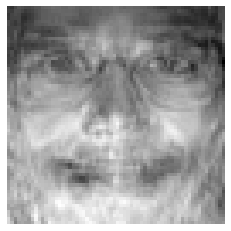

In [263]:
def plot_reconstructed_face(pca, X):
    X_reduced = pca.transform(X)
    X_preimage = pca.inverse_transform(X_reduced)
    plot_face(X_preimage)
    
plot_reconstructed_face(pca, modded_samples[0].reshape(1,-1))

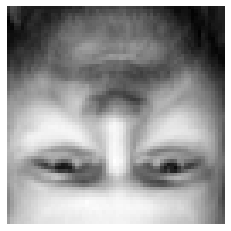

In [266]:
plot_face(modded_samples[0])

Holy shiz that is the stuff of nightmares!!! Indeed - it is trying to reconstruct it as a normal face instead of a modded one!

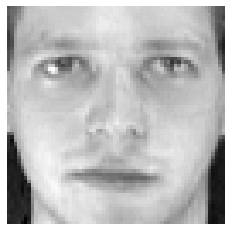

In [264]:
plot_reconstructed_face(pca, X[[0]])

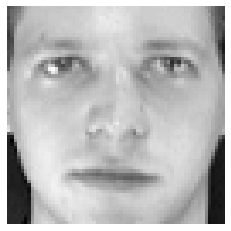

In [265]:
plot_face(X[0])